In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
print(torch.__version__)
print(torchvision.__version__)

2.0.1
0.15.2


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

In [6]:
# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device) #<- model saved at /root/.cache/torch/hub/checkpoints/

In [5]:
# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

In [4]:
image_root_path = "/shared-volume/UNATA STORAGE/docker_shared_files/data_root_own_laptop/data/image_datasets/intel_kaggle_dataset"

NUM_WORKERS = 1 #os.cpu_count()

# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
    """Creates training and testing DataLoaders.

    Takes in a training directory and testing directory path and turns
    them into PyTorch Datasets and then into PyTorch DataLoaders.

    Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

    Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
    """
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
    )
    test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [5]:
# torchinfo.summary(pretrained_vit, input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [6]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [7]:
train_loader, test_loader, class_names = create_dataloaders(image_root_path+"/train", image_root_path+"/test",
                                              transform=pretrained_vit_transforms, batch_size=16, num_workers=NUM_WORKERS)
# test_loader = create_dataloaders(test_set, shuffle=False, batch_size=128)

In [9]:
# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
# set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [11]:
model = pretrained_vit
model = model.to("cuda")

In [12]:
epochs = 5
train_losses = []
valid_losses = []
train_accuracies = []
val_accuracies = []
best_val_loss = 1e9

In [13]:
optim = torch.optim.Adam(model.parameters(),lr=0.001)
sched = torch.optim.lr_scheduler.OneCycleLR(optim,max_lr=0.001,steps_per_epoch=len(train_loader),epochs=epochs)

In [14]:
for ep in tqdm(range(epochs)):
    model.train()
    trl = 0.
    train_acc = 0.
    tprog = tqdm(enumerate(train_loader),total=len(train_loader))
    for i, (input_ids, labels) in tprog:
        input_ids = input_ids.to('cuda')
        labels = labels.to('cuda')
        y_pred = model(input_ids)
        loss = F.cross_entropy(y_pred,labels)
        loss.backward()
        optim.step()
        optim.zero_grad()
        sched.step()
        trl += loss.item()
        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == labels).sum().item()/len(y_pred)
        
        tprog.set_description(f'train step loss: {loss.item():.4f}')
    train_losses.append(trl/len(train_loader))
    train_accuracies.append(train_acc/len(train_loader))
    
    model.eval()
    with torch.no_grad():
        vrl = 0.
        val_acc = 0.
        vprog = tqdm(enumerate(test_loader),total=len(test_loader))
        for i, (input_ids, labels) in vprog:

            input_ids = input_ids.to('cuda')
            labels = labels.to('cuda')
            y_pred = model(input_ids)
            loss = F.cross_entropy(y_pred,labels)
            vrl += loss.item()
            
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            val_acc += (y_pred_class == labels).sum().item()/len(y_pred)
            
            vprog.set_description(f'valid step loss: {loss.item():.4f}')
        vloss = vrl/len(test_loader)
        valid_losses.append(vloss)
        val_accuracies.append(val_acc/len(test_loader))
    print(f'epoch {ep} | train_loss: {train_losses[-1]:.4f}   train_acc: {train_accuracies[-1]:.4f} valid_loss: {valid_losses[-1]:.4f}   valid_acc: {val_accuracies[-1]:.4f}')

train step loss: 1.4246:  11%|█▊               | 96/878 [00:20<02:28,  5.27it/s]


train step loss: 0.9298:  22%|███▌            | 193/878 [00:39<02:14,  5.11it/s]


train step loss: 0.4600:  33%|█████▎          | 290/878 [00:58<01:52,  5.23it/s]


train step loss: 0.6116:  44%|███████         | 387/878 [01:17<01:40,  4.89it/s]


train step loss: 0.2377:  55%|████████▊       | 484/878 [01:36<01:21,  4.86it/s]


train step loss: 0.2726:  66%|██████████▌     | 581/878 [01:56<01:01,  4.82it/s]


train step loss: 0.2196:  77%|████████████▎   | 678/878 [02:16<00:41,  4.81it/s]


train step loss: 0.2265:  88%|██████████████  | 775/878 [02:36<00:21,  4.82it/s]


train step loss: 0.1878:  99%|███████████████▉| 872/878 [02:57<00:01,  4.30it/s]


train step loss: 0.5595: 100%|████████████████| 878/878 [02:58<00:00,  4.92it/s]

valid step loss: 0.6670:  48%|████████▏        | 91/188 [00:21<00:23,  4.04it/s]


 20%|████████▊                                   | 1/5 [03:46<15:04, 226.07s/it]

epoch 0 | train_loss: 0.6393   train_acc: 0.8080 valid_loss: 0.2342   valid_acc: 0.9222



train step loss: 0.2434:  11%|█▊               | 96/878 [00:28<03:48,  3.42it/s]


train step loss: 0.2271:  22%|███▌            | 193/878 [01:00<03:51,  2.96it/s]


train step loss: 0.1594:  33%|█████▎          | 290/878 [01:35<03:57,  2.47it/s]


train step loss: 0.0848:  44%|███████         | 387/878 [02:15<03:21,  2.44it/s]


train step loss: 0.1783:  55%|████████▊       | 484/878 [02:57<02:59,  2.20it/s]


train step loss: 0.0698:  66%|██████████▌     | 581/878 [03:38<02:11,  2.25it/s]


train step loss: 0.1322:  77%|████████████▎   | 678/878 [04:21<01:30,  2.21it/s]


train step loss: 0.1113:  88%|██████████████  | 775/878 [05:06<01:01,  1.67it/s]


train step loss: 0.0879:  99%|███████████████▉| 872/878 [05:57<00:02,  2.04it/s]


train step loss: 0.0013: 100%|████████████████| 878/878 [05:59<00:00,  2.44it/s]

valid step loss: 0.4779:  48%|████████▏        | 91/188 [00:47<00:50,  1.92it/s]


 40%|█████████████████▌                          | 2/5 [11:24<18:08, 362.89s/it]

epoch 1 | train_loss: 0.2104   train_acc: 0.9277 valid_loss: 0.1952   valid_acc: 0.9312



train step loss: 0.2055:  11%|█▊               | 96/878 [00:53<07:05,  1.84it/s]


train step loss: 0.5652:  22%|███▌            | 193/878 [01:35<04:17,  2.67it/s]


train step loss: 0.1155:  33%|█████▎          | 290/878 [02:06<02:55,  3.35it/s]


train step loss: 0.0411:  44%|███████         | 387/878 [02:35<02:25,  3.38it/s]


train step loss: 0.5472:  55%|████████▊       | 484/878 [03:03<01:45,  3.74it/s]


train step loss: 0.2622:  66%|██████████▌     | 581/878 [03:30<01:24,  3.50it/s]


train step loss: 0.5009:  77%|████████████▎   | 678/878 [03:57<00:52,  3.78it/s]


train step loss: 0.1090:  88%|██████████████  | 775/878 [04:23<00:30,  3.40it/s]


train step loss: 0.1412:  99%|███████████████▉| 872/878 [04:50<00:01,  3.58it/s]


train step loss: 0.0006: 100%|████████████████| 878/878 [04:51<00:00,  3.01it/s]

valid step loss: 0.4998:  48%|████████▏        | 91/188 [00:23<00:24,  3.93it/s]


 60%|██████████████████████████▍                 | 3/5 [17:04<11:44, 352.21s/it]

epoch 2 | train_loss: 0.1768   train_acc: 0.9376 valid_loss: 0.1805   valid_acc: 0.9355



train step loss: 0.1092:  11%|█▊               | 96/878 [00:25<03:41,  3.53it/s]


train step loss: 0.1468:  22%|███▌            | 193/878 [00:50<03:02,  3.74it/s]


train step loss: 0.0777:  33%|█████▎          | 290/878 [01:16<02:37,  3.73it/s]


train step loss: 0.1367:  44%|███████         | 387/878 [01:42<02:11,  3.73it/s]


train step loss: 0.1878:  55%|████████▊       | 484/878 [02:08<01:45,  3.74it/s]


train step loss: 0.3742:  66%|██████████▌     | 581/878 [02:34<01:24,  3.52it/s]


train step loss: 0.4414:  77%|████████████▎   | 678/878 [03:01<00:52,  3.83it/s]


train step loss: 0.1525:  88%|██████████████  | 775/878 [03:26<00:26,  3.83it/s]


train step loss: 0.0274:  99%|███████████████▉| 872/878 [03:51<00:01,  3.82it/s]


train step loss: 0.0023: 100%|████████████████| 878/878 [03:53<00:00,  3.77it/s]

valid step loss: 0.5254:  48%|████████▏        | 91/188 [00:23<00:24,  3.91it/s]


 80%|███████████████████████████████████▏        | 4/5 [21:45<05:24, 324.09s/it]

epoch 3 | train_loss: 0.1583   train_acc: 0.9438 valid_loss: 0.1793   valid_acc: 0.9362



train step loss: 0.3426:  11%|█▊               | 96/878 [00:26<03:37,  3.60it/s]


train step loss: 0.3188:  22%|███▌            | 193/878 [00:52<02:59,  3.81it/s]


train step loss: 0.0204:  33%|█████▎          | 290/878 [01:17<02:33,  3.82it/s]


train step loss: 0.1662:  44%|███████         | 387/878 [01:43<02:08,  3.81it/s]


train step loss: 0.0780:  55%|████████▊       | 484/878 [02:09<01:43,  3.82it/s]


train step loss: 0.2342:  66%|██████████▌     | 581/878 [02:36<01:22,  3.61it/s]


train step loss: 0.2928:  77%|████████████▎   | 678/878 [03:03<00:55,  3.61it/s]


train step loss: 0.0535:  88%|██████████████  | 775/878 [03:29<00:26,  3.89it/s]


train step loss: 0.0491:  99%|███████████████▉| 872/878 [03:54<00:01,  3.73it/s]


train step loss: 0.0020: 100%|████████████████| 878/878 [03:56<00:00,  3.72it/s]

valid step loss: 0.5104:  48%|████████▏        | 91/188 [00:23<00:25,  3.87it/s]


100%|████████████████████████████████████████████| 5/5 [26:30<00:00, 318.17s/it]

epoch 4 | train_loss: 0.1472   train_acc: 0.9479 valid_loss: 0.1781   valid_acc: 0.9358


In [19]:
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name
    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

In [20]:
save_model(model, "/shared-volume/UNATA STORAGE/docker_shared_files/models/","intel_kaggle_data_ViT_classifier_finetuned.pth")

[INFO] Saving model to: /shared-volume/UNATA STORAGE/docker_shared_files/models/intel_kaggle_data_ViT_classifier_finetuned.pth


### Load Saved Model

In [10]:
"""
Utility functions to make predictions.

Main reference for code creation: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set 
"""
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple

from PIL import Image

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Predict on a target image with a target model
# Function created in: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)


In [11]:
pretrained_vit = torchvision.models.vit_b_16()

In [14]:
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [18]:
pretrained_vit.load_state_dict(torch.load("/shared-volume/UNATA STORAGE/docker_shared_files/models/intel_kaggle_data_ViT_classifier_finetuned.pth", weights_only=True, map_location="cuda:0"))

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


<All keys matched successfully>

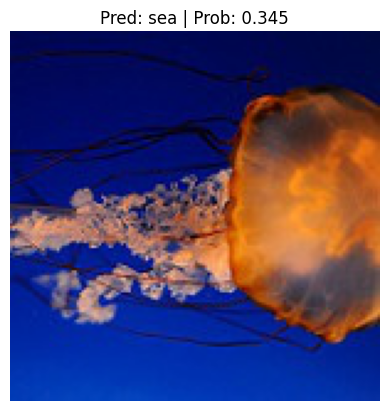

In [32]:
import requests

# Setup custom image path
custom_image_path = image_root_path +"/pred/seg_pred/"+"63.jpg"

# # Download the image if it doesn't already exist
# if not custom_image_path.is_file():
#     with open(custom_image_path, "wb") as f:
#         # When downloading from GitHub, need to use the "raw" file link
#         request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
#         print(f"Downloading {custom_image_path}...")
#         f.write(request.content)
# else:
#     print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit, transform=pretrained_vit_transforms,
                    image_path=custom_image_path,
                    class_names=class_names)